<h1 align="center" style="color: #F99417"> The Python Interpreter and the CPython Implementation </h1>

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/warning.svg">
>   <img alt="Warning" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/warning.svg">
> </picture><br>
>
> For data scientist or pretty much anyone working with python it is **not** essential to understand the internals of the python interpreter; unless you are working on a project that requires you to do so.

**[Adapted from talk at North bay python by James Bennett](https://youtu.be/tzYhv61piNY?si=viI5Rjd54vehuy2F)**

In this notebook, we will try to understand how the python interpreter works and how the CPython implementation is structured.

## How source code gets converted to machine code in Python ? 

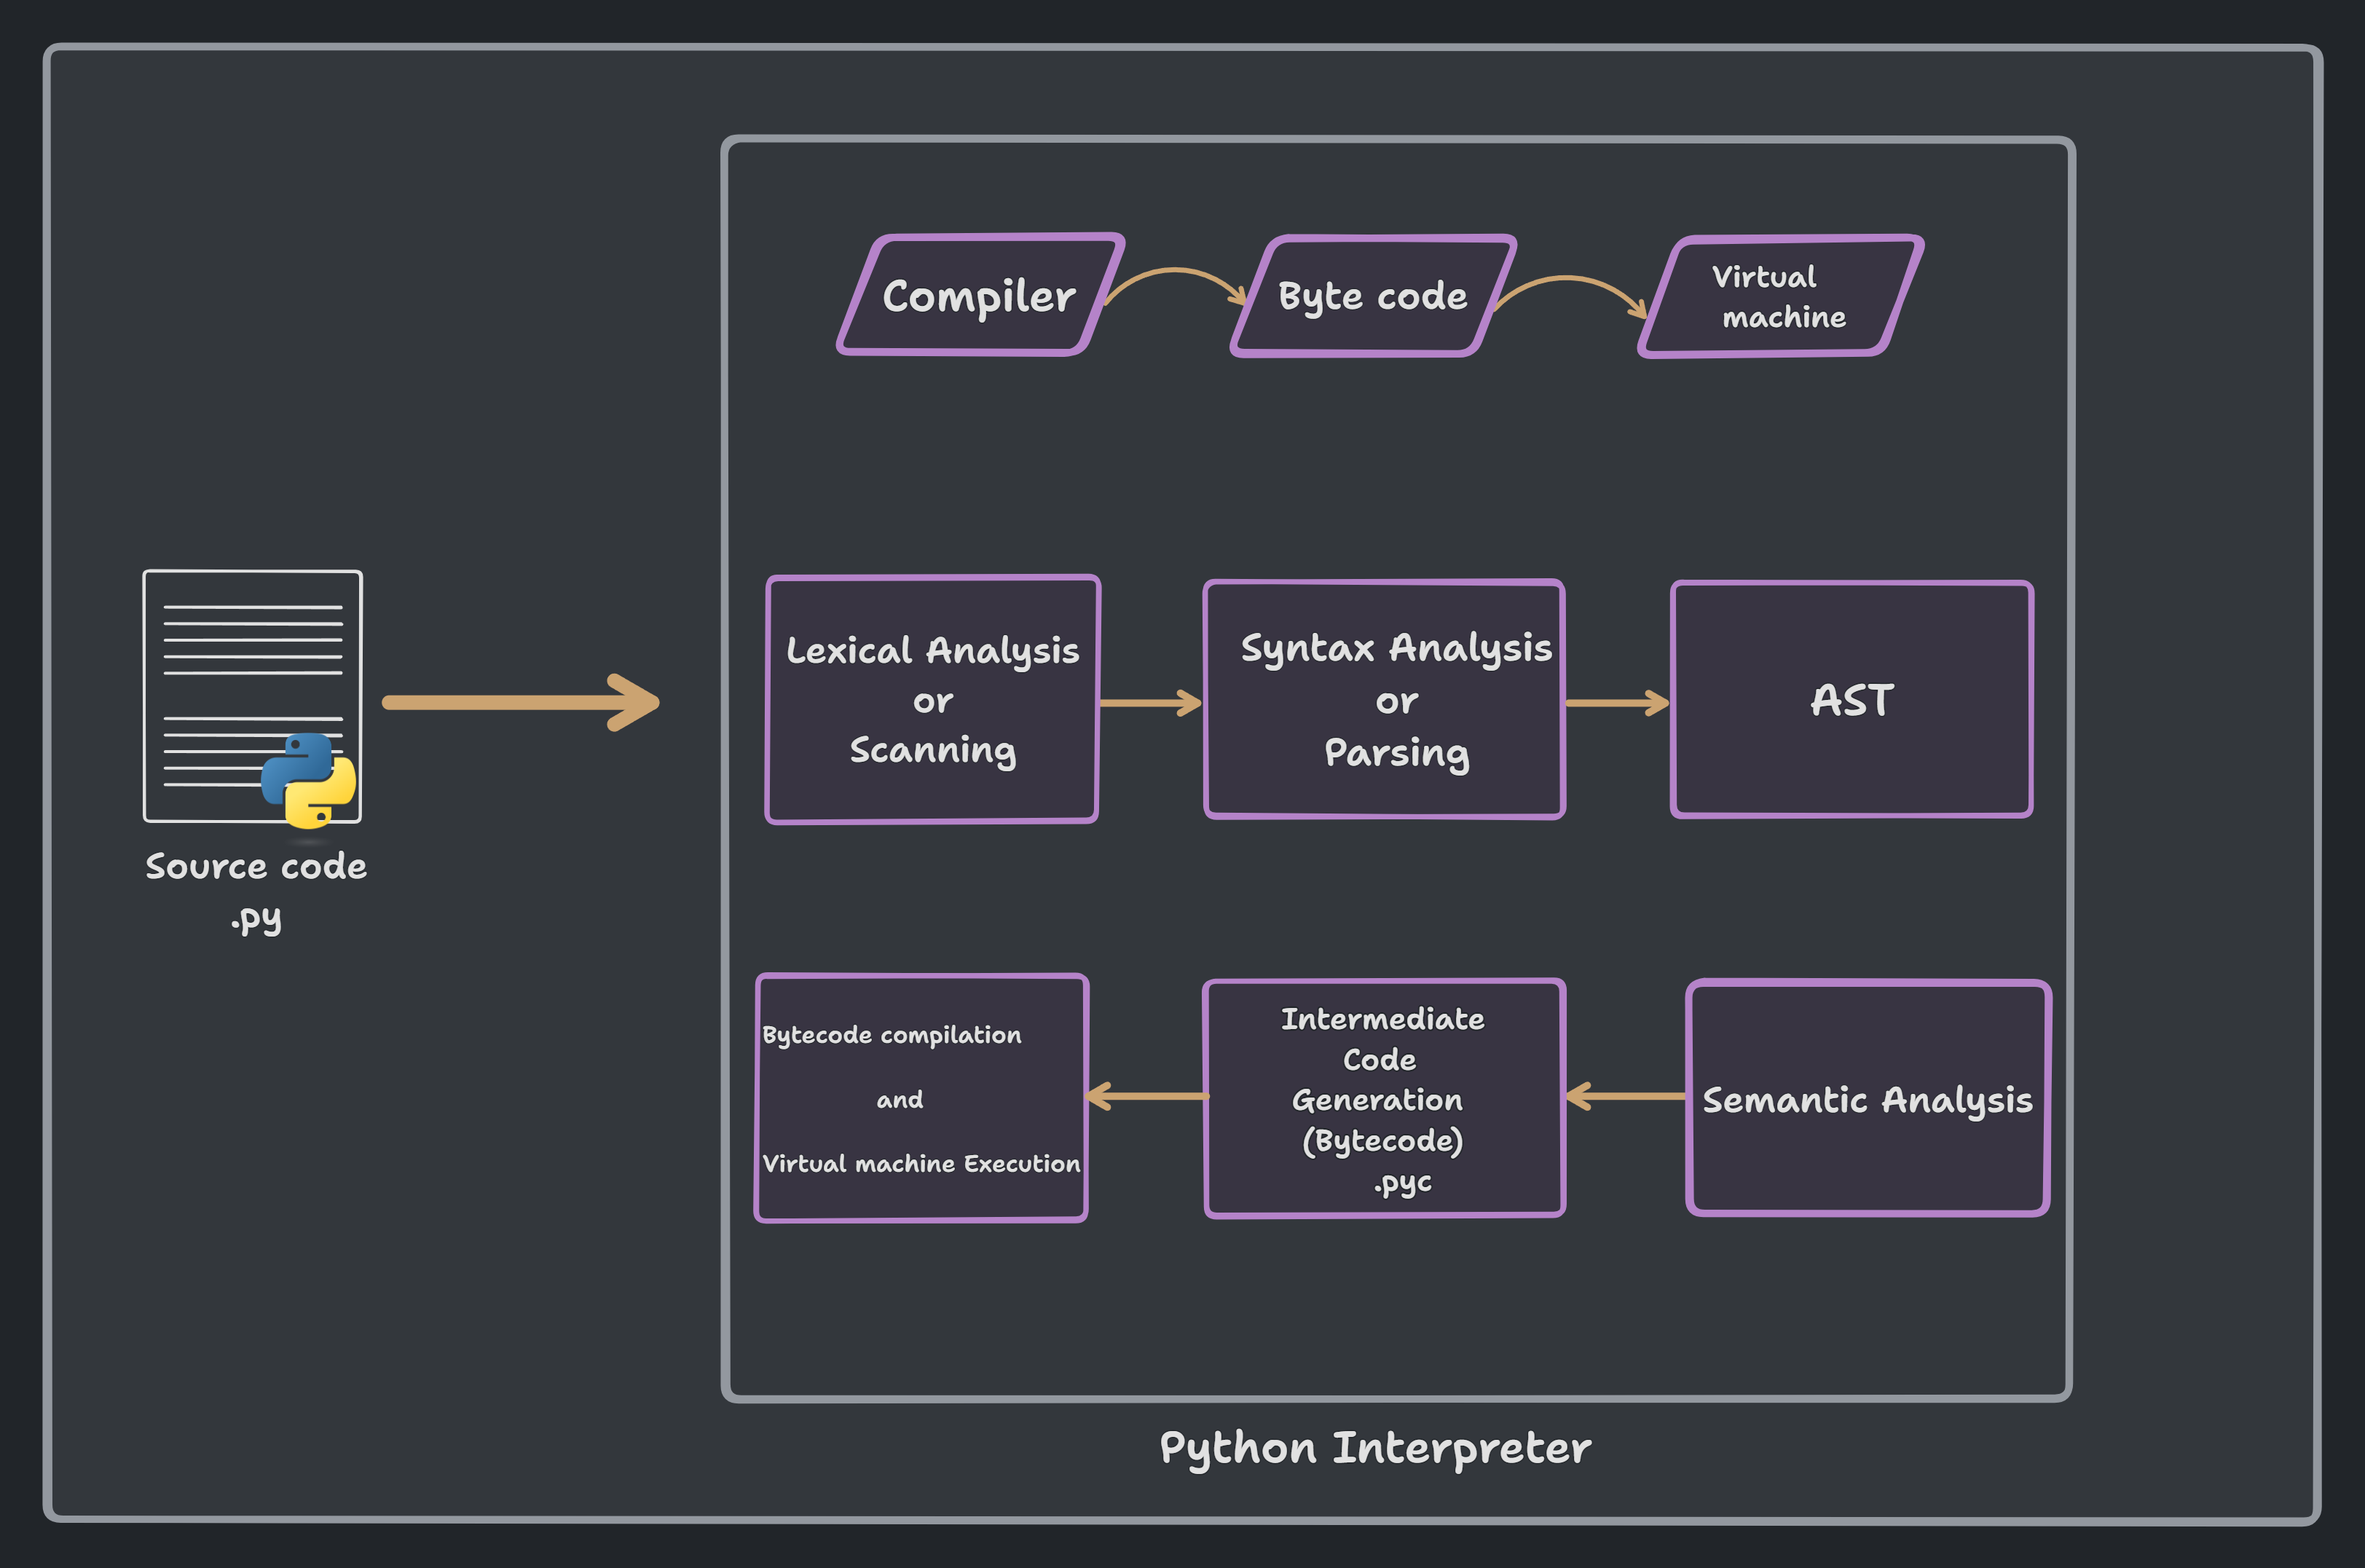

**CPython** is many things;

- A python interpreter
- A parser
- A compiler
- A virtual machine
- A standard library
- and a programmable C API and so on...

In [9]:
# some tools for inspection
import ast, inspect, pprint, dis

- `ast` module : Abstract Syntax Trees
- `inspect` module : Inspect live objects (classes, methods, functions, etc)
- `pprint` module : Pretty-print data structures
- `dis` module : Disassembler for Python bytecode

In [11]:
def fast_week():
    return 7 * 86400

def slow_week():
    seconds_per_day = 86400
    return seconds_per_day * 7

In [12]:
%timeit fast_week()

65.1 ns ± 1.37 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [13]:
%timeit slow_week()

108 ns ± 2.59 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


Simply assigning a variable shouldn't take that much time, right ? Even if it may take some extra time but certainly not almost 50% difference. So what is happening here ? 

In [14]:
pprint.pprint(
    ast.dump(
        ast.parse(
            inspect.getsource(slow_week)
        )
    )
)

("Module(body=[FunctionDef(name='slow_week', args=arguments(posonlyargs=[], "
 'args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), '
 "body=[Assign(targets=[Name(id='seconds_per_day', ctx=Store())], "
 'value=Constant(value=86400)), '
 "Return(value=BinOp(left=Name(id='seconds_per_day', ctx=Load()), op=Mult(), "
 'right=Constant(value=7)))], decorator_list=[])], type_ignores=[])')


In [15]:
dis.dis(slow_week)

  4           0 RESUME                   0

  5           2 LOAD_CONST               1 (86400)
              4 STORE_FAST               0 (seconds_per_day)

  6           6 LOAD_FAST                0 (seconds_per_day)
              8 LOAD_CONST               2 (7)
             10 BINARY_OP                5 (*)
             14 RETURN_VALUE


When you run the function `slow_week()`, this is what the python interpreter is doing:

```assembly

  4           0 RESUME                   0

  5           2 LOAD_CONST               1 (86400)
              4 STORE_FAST               0 (seconds_per_day)

  6           6 LOAD_FAST                0 (seconds_per_day)
              8 LOAD_CONST               2 (7)
             10 BINARY_OP                5 (*)
             14 RETURN_VALUE
```

and when we wrote the function, this is what actually the python interpreter saw:

```
Module(

  body=[
    FunctionDef(
      name='slow_week', args=arguments(posonlyargs=[], "
 'args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), '

 "body=[Assign(targets=[Name(id='seconds_per_day', ctx=Store())], "

 'value=Constant(value=86400)), '

 "Return(
        value=BinOp(left=Name(id='seconds_per_day', ctx=Load()), op=Mult(), "
 'right=Constant(value=7)))], decorator_list=[])], type_ignores=[]
 )
```


Let us look at the AST of this function

In [21]:
tree = ast.parse(inspect.getsource(slow_week))

print(tree)
print(tree.body[0])
print(tree.body[0].body)

[<ast.Assign object at 0x000002462E270430>, <ast.Return object at 0x000002462E271360>]


In [28]:
# poking around some dunder-methods

print(slow_week.__code__)
print(slow_week.__code__.co_consts)     # python keeps None as return type if it need to return None implicitly
print(slow_week.__code__.co_varnames)
print(slow_week.__code__.co_code)       # Actual bytecode 


<code object slow_week at 0x000002462E288D30, file "C:\Users\kanna\AppData\Local\Temp\ipykernel_18144\1451787921.py", line 4>
(None, 86400, 7)
('seconds_per_day',)
b'\x97\x00d\x01}\x00|\x00d\x02z\x05\x00\x00S\x00'


We can verify the last line of code in the above cell indeed produce the bytecode

In [30]:
print(dis.opname[slow_week.__code__.co_code[0]])
print(dis.opname[slow_week.__code__.co_code[2]])
print(dis.opname[slow_week.__code__.co_code[4]])

RESUME
LOAD_CONST
STORE_FAST


Going by increment of 2 cause bytecode comes in two byte units, First byte is the instruction and second byte is the argument to that instruction.

CPython is a stack based virtual machine. It has a stack and a frame. The frame is where the local variables are stored. The stack is where the operations are performed. The stack is also where the arguments to functions are passed.

If we look at the `fast_week()` function, we can see the reason for the time difference in execution


In [31]:
dis.dis(fast_week)

  1           0 RESUME                   0

  2           2 LOAD_CONST               1 (604800)
              4 RETURN_VALUE


Since, the calculation in `fast_week()` is not going to change, the interpreter, at the time of bytecode compilation did the calculation and stored the result in the bytecode itself. So, when the function is called, the interpreter just returns the result from the bytecode. This is called **constant folding**.

## Global Interpreter Lock (GIL)

The GIL is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once. This lock is necessary mainly because CPython’s memory management is not thread-safe. (However, since the GIL exists, other features have grown to depend on the guarantees that it enforces.). The biggest drawback of having the GIL is that if you are running a multi-threaded application, you cannot take advantage of multiple cores. This is because the GIL only allows one thread to execute at a time, even if you’re on a multi-core machine. There has been many attempt to remove the GIL from CPython and even a project from google called `Gilectomy`, which is kind of dead now. Other Python implementations like Jython (Python on the JVM) or IronPython (Python on .NET) do not have a GIL.

But if we need to fully utilize multi-core processors for CPU-bound tasks in Python, we may use multiprocessing or alternative concurrency models like asyncio for I/O-bound tasks. Again python is not the best language for CPU-bound tasks and to an extend python overcome this by providing only high-level function calling interface or API's in native code and leaving the actual implementation to the underlying C code.

On January 2023; The Python Steering Council has announced its intention to accept PEP 703, which would make the global interpreter lock (GIL) optional in CPython. This would be implemented in stages.